# Pipeline de Catégorisation de Dépôts GitHub avec des Embeddings Sémantiques

**Objectif :** Ce notebook a pour but de récupérer des données détaillées de dépôts GitHub, de transformer leurs informations textuelles en vecteurs sémantiques (embeddings) à l'aide d'un modèle de `transformers`, puis d'utiliser le clustering pour regrouper automatiquement ces dépôts en ~15 catégories pertinentes.

In [2]:
!pip install requests pandas ijson tqdm transformers torch scikit-learn numpy matplotlib seaborn umap-learn

In [ ]:
import requests
import pandas as pd
import json
import os
import gc
from tqdm.notebook import tqdm  # Utiliser tqdm.notebook pour un meilleur affichage dans les notebooks
from time import sleep
import ijson
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import numpy as np
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

# --- CONFIGURATION ---

# ATTENTION : Ne jamais stocker de token en clair dans un notebook.
# Idéalement, utilisez des variables d'environnement ou un gestionnaire de secrets.
TOKEN = os.getenv("GITHUB_TOKEN")
 # Remplacez par votre token
HEADERS = {'Authorization': f'token {TOKEN}', 'Accept': 'application/vnd.github.v3+json'}

# Fichiers
INPUT_FILE = "repos-min-1000stars.json"
OUTPUT_FILE = "github_repos_categorized.csv"

# Paramètres du script
BATCH_SIZE = 500      # Sauvegarder tous les 500 dépôts traités
RATE_LIMIT_SLEEP = 1  # Secondes entre les requêtes pour ne pas surcharger l'API
LIMIT = 2000          # Nombre de dépôts à traiter (à ajuster selon vos ressources)
N_CATEGORIES = 15     # Nombre de catégories cibles

# Vérification de la disponibilité du GPU pour PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device : {device}")

Utilisation du device : cpu


In [4]:
def json_stream(file_path, limit=None):
    """Lit un gros fichier JSON de manière itérative."""
    with open(file_path, "r", encoding="utf-8") as f:
        for i, repo in enumerate(ijson.items(f, "item")):
            if limit and i >= limit:
                break
            yield repo

def get_github_json(url):
    """Fait une requête GET à l'API GitHub avec gestion basique du rate limiting."""
    try:
        r = requests.get(url, headers=HEADERS)
        if r.status_code == 200:
            return r.json()
        elif r.status_code == 403:
            print("⏳ Rate limit atteint, pause de 60s...")
            sleep(60)
            return get_github_json(url) # On réessaie
        else:
            print(f"⚠️ Code d'erreur {r.status_code} pour {url}")
            return None
    except Exception as e:
        print(f"💥 Erreur de connexion sur {url}: {e}")
    return None

print("Fonctions d'extraction prêtes.")

Fonctions d'extraction prêtes.


In [5]:
# --- PIPELINE D'EXTRACTION ---
data = []
# On s'assure que le fichier de sortie n'existe pas pour éviter les doublons lors d'une nouvelle exécution
if os.path.exists(OUTPUT_FILE):
    os.remove(OUTPUT_FILE)

# Création du DataFrame final
all_repos_df = pd.DataFrame()

# Itération sur le fichier JSON d'entrée
for i, repo in enumerate(tqdm(json_stream(INPUT_FILE, limit=LIMIT), total=LIMIT, desc="1/5 - Extraction des dépôts")):
    repo_data = {
        "full_name": repo.get("full_name"),
        "html_url": repo.get("html_url"),
        "description": repo.get("description"),
        "language": repo.get("language"),
        "stars": repo.get("stargazers_count"),
    }

    # Récupération des données additionnelles via l'API
    commits = get_github_json(repo["commits_url"].replace("{/sha}", "?per_page=5"))
    repo_data["recent_commit_messages"] = " ".join([c["commit"]["message"] for c in commits if c and "commit" in c]) if commits else ""

    pulls = get_github_json(repo["pulls_url"].replace("{/number}", "?state=all&per_page=5"))
    repo_data["recent_pr_titles"] = " ".join([p["title"] for p in pulls if p and "title" in p]) if pulls else ""
    
    issues = get_github_json(repo["issues_url"].replace("{/number}", "?state=open&per_page=5"))
    repo_data["recent_issue_titles"] = " ".join([i["title"] for i in issues if i and "title" in i]) if issues else ""
    
    data.append(repo_data)
    sleep(RATE_LIMIT_SLEEP) # Délai pour respecter l'API

    # Sauvegarde par lot (utile pour les très grosses extractions)
    if (i + 1) % BATCH_SIZE == 0:
        temp_df = pd.DataFrame(data)
        all_repos_df = pd.concat([all_repos_df, temp_df], ignore_index=True)
        data.clear()
        gc.collect()

# Sauvegarde du dernier lot
if data:
    temp_df = pd.DataFrame(data)
    all_repos_df = pd.concat([all_repos_df, temp_df], ignore_index=True)

print(f"\n✅ Extraction terminée. {len(all_repos_df)} dépôts collectés.")
all_repos_df.head()

1/5 - Extraction des dépôts:   0%|          | 0/2000 [00:00<?, ?it/s]

💥 Erreur de connexion sur https://api.github.com/repos/open-source-labs/SvelteStorm/pulls?state=all&per_page=5: ('Connection aborted.', ConnectionResetError(104, 'Connection reset by peer'))
⚠️ Code d'erreur 404 pour https://api.github.com/repos/miao1007/Openwrt-NetKeeper/commits?per_page=5
⚠️ Code d'erreur 404 pour https://api.github.com/repos/miao1007/Openwrt-NetKeeper/pulls?state=all&per_page=5
⚠️ Code d'erreur 404 pour https://api.github.com/repos/miao1007/Openwrt-NetKeeper/issues?state=open&per_page=5

✅ Extraction terminée. 2000 dépôts collectés.


,full_name,html_url,description,language,stars,recent_commit_messages,recent_pr_titles,recent_issue_titles
0,mdbootstrap/bootstrap-toggle-buttons,https://github.com/mdbootstrap/bootstrap-toggl...,Bootstrap-toggle-buttons has moved to https://...,JavaScript,1013,Update README.md add old documentation goodbye...,Less support when using custom background grad...,Does not work with jquery-1.10.2.js jQuery Pro...
1,cloudfuji/kandan,https://github.com/cloudfuji/kandan,A Cloudfuji chat application,JavaScript,1005,Update README to point to https://github.com/k...,Update README.md Correctly set channel and use...,
2,doug/depthjs,https://github.com/doug/depthjs,DepthJS allows any web page to interact with t...,C++,1003,mac os 10.7 universal prebuilt binary readme.....,Update Mac Chrome Plugin for latest Chrome ver...,Is depthjs still maintained ? Linking referenc...
3,codrops/ModalWindowEffects,https://github.com/codrops/ModalWindowEffects,A set of experimental modal window appearance ...,JavaScript,1015,initial commit,,Some NavBar elements are showing above the mod...
4,adactio/Pattern-Primer,https://github.com/adactio/Pattern-Primer,Generating styled markup from a folder of mark...,CSS,1002,Merge pull request #4 from Upperdog/master\n\n...,Ignore Vim's .swp files Update the display if ...,Update the display if the source is updated sn...


In [12]:
def combine_text_features(row):
    """Combine les champs textuels en un seul document par dépôt."""
    # On donne plus de poids à la description en la répétant
    description = str(row['description']) if pd.notna(row['description']) else ''
    language = str(row['language']) if pd.notna(row['language']) else ''
    commits = str(row['recent_commit_messages']) if pd.notna(row['recent_commit_messages']) else ''
    
    # On assemble le tout en un seul texte
    # Le nom du langage est important pour la catégorisation
    return f"Language: {language}. Description: {description}. Recent commits: {commits}"

In [13]:
def combine_text_features(row):
    """Combine les champs textuels en un seul document par dépôt."""
    # On donne plus de poids à la description en la répétant
    description = str(row['description']) if pd.notna(row['description']) else ''
    #language = str(row['language']) if pd.notna(row['language']) else ''
    #commits = str(row['recent_commit_messages']) if pd.notna(row['recent_commit_messages']) else ''
    
    # On assemble le tout en un seul texte
    # Le nom du langage est important pour la catégorisation
    return f"Description: {description}"

# Création d'une colonne contenant tout le texte à analyser
tqdm.pandas(desc="2/5 - Combinaison des textes")
all_repos_df['full_text'] = all_repos_df.progress_apply(combine_text_features, axis=1)

# Affichage d'un exemple
print(all_repos_df['full_text'].iloc[0])

2/5 - Combinaison des textes:   0%|          | 0/2000 [00:00<?, ?it/s]

Description: Bootstrap-toggle-buttons has moved to https://github.com/nostalgiaz/bootstrap-switch


In [14]:
# --- FONCTIONS HUGGING FACE ---

def mean_pooling(model_output, attention_mask):
    """Pooling pour obtenir un embedding de phrase."""
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Chargement du modèle et du tokenizer
print("Chargement du modèle 'all-MiniLM-L6-v2'...")
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to(device) # On envoie le modèle sur le GPU si disponible
print("Modèle chargé.")


def get_embeddings(sentences, batch_size=32):
    """Génère les embeddings pour une liste de phrases."""
    all_embeddings = []
    # On traite les phrases par lots pour ne pas saturer la mémoire (surtout sur GPU)
    for i in tqdm(range(0, len(sentences), batch_size), desc="3/5 - Génération des Embeddings"):
        batch = sentences[i:i+batch_size]
        
        encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt').to(device)
        
        with torch.no_grad():
            model_output = model(**encoded_input)
            
        sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
        sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
        
        # On renvoie les embeddings sur le CPU pour les manipuler avec numpy/pandas
        all_embeddings.append(sentence_embeddings.cpu().numpy())
        
    return np.vstack(all_embeddings)

# Génération des embeddings pour tous nos dépôts
corpus = all_repos_df['full_text'].tolist()
embeddings = get_embeddings(corpus)

print(f"\nEmbeddings générés. Shape: {embeddings.shape}") # (nombre de dépôts, dimension de l'embedding)

Chargement du modèle 'all-MiniLM-L6-v2'...


'(ReadTimeoutError("HTTPSConnectionPool(host='huggingface.co', port=443): Read timed out. (read timeout=10)"), '(Request ID: 314bfb60-fa8e-47b5-a185-0b1a5bf10aea)')' thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/tokenizer_config.json
Retrying in 1s [Retry 1/5].


Modèle chargé.


3/5 - Génération des Embeddings:   0%|          | 0/63 [00:00<?, ?it/s]


Embeddings générés. Shape: (2000, 384)


In [15]:
# Utilisation de K-Means pour regrouper les dépôts en N catégories
kmeans = KMeans(n_clusters=N_CATEGORIES, random_state=42, n_init=10)

# Le clustering se fait sur les embeddings haute-dimension
tqdm.pandas(desc="4/5 - Clustering des dépôts")
all_repos_df['category_id'] = kmeans.fit_predict(embeddings)

print(f"\nClustering terminé. {N_CATEGORIES} catégories créées.")
print("Distribution des dépôts par catégorie :")
print(all_repos_df['category_id'].value_counts().sort_index())


Clustering terminé. 15 catégories créées.
Distribution des dépôts par catégorie :
category_id
0     173
1     155
2     175
3      82
4     152
5      81
6     215
7      75
8     167
9     141
10    117
11     59
12    108
13    104
14    196
Name: count, dtype: int64


In [16]:
print("5/5 - Analyse des catégories pour les nommer...")

# On utilise TF-IDF pour trouver les mots-clés les plus pertinents de chaque cluster
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(all_repos_df['full_text'])
terms = vectorizer.get_feature_names_out()

category_names = {}

for i in range(N_CATEGORIES):
    cluster_df = all_repos_df[all_repos_df['category_id'] == i]
    
    # Indices des dépôts du cluster actuel
    indices = cluster_df.index
    
    # Score TF-IDF moyen pour chaque mot dans ce cluster
    mean_tfidf = np.asarray(tfidf_matrix[indices].mean(axis=0)).ravel()
    
    # Top 10 des mots-clés
    top_indices = mean_tfidf.argsort()[-10:][::-1]
    keywords = [terms[j] for j in top_indices]
    
    # Exemples de dépôts et de langages
    top_languages = cluster_df['language'].value_counts().nlargest(3).index.tolist()
    example_repos = cluster_df['full_name'].head(3).tolist()
    
    print(f"\n--- Catégorie {i} ---")
    print(f"  Nombre de dépôts : {len(cluster_df)}")
    print(f"  Mots-clés principaux : {', '.join(keywords)}")
    print(f"  Langages dominants : {', '.join(map(str, top_languages))}")
    print(f"  Exemples : {', '.join(example_repos)}")
    
    # Suggestion de nom (à affiner manuellement)
    # C'est une heuristique simple, vous pouvez la rendre plus intelligente
    suggested_name = f"{top_languages[0]}_{keywords[0]}_{keywords[1]}" if top_languages else f"Cluster_{keywords[0]}"
    category_names[i] = suggested_name

# Appliquer les noms de catégories suggérés au DataFrame
all_repos_df['category_name'] = all_repos_df['category_id'].map(category_names)

5/5 - Analyse des catégories pour les nommer...

--- Catégorie 0 ---
  Nombre de dépôts : 173
  Mots-clés principaux : description, client, http, server, api, proxy, protocol, using, web, dns
  Langages dominants : Python, JavaScript, Go
  Exemples : cloudfuji/kandan, facebookarchive/relay-starter-kit, ryhanson/phishery

--- Catégorie 1 ---
  Nombre de dépôts : 155
  Mots-clés principaux : description, chinese, web, linux, ai, https, font, deprecated, api, android
  Langages dominants : Python, Java, JavaScript
  Exemples : chemdemo/chemdemo.github.io, qifengdeqingchen/SeatTable, StevenCui/VIO-Doc

--- Catégorie 2 ---
  Nombre de dépôts : 175
  Mots-clés principaux : description, rust, library, code, java, golang, source, tool, language, performance
  Langages dominants : Go, Rust, C++
  Exemples : mdsecactivebreach/CACTUSTORCH, crcn/mesh.js, sagishahar-zz/lpeworkshop

--- Catégorie 3 ---
  Nombre de dépôts : 82
  Mots-clés principaux : description, zip, formats, fork, font, focused, f

Réduction de la dimensionnalité avec UMAP pour la visualisation...


/usr/local/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


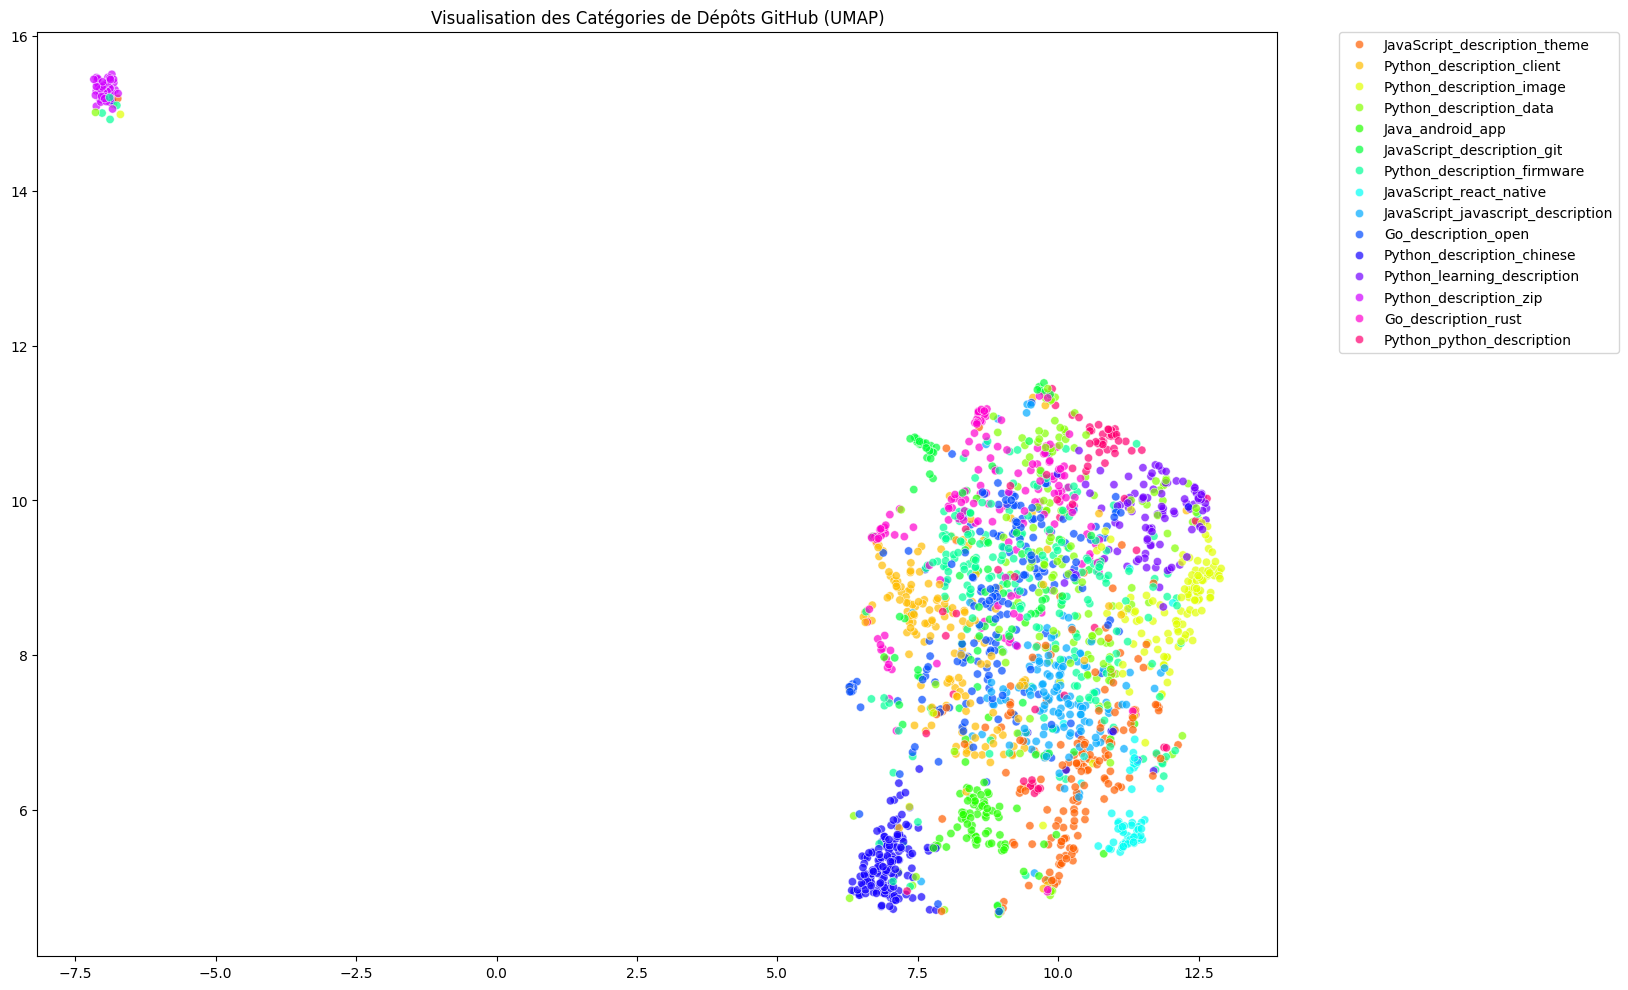

In [17]:
try:
    from umap import UMAP
    
    print("Réduction de la dimensionnalité avec UMAP pour la visualisation...")
    reducer = UMAP(n_components=2, random_state=42)
    embeddings_2d = reducer.fit_transform(embeddings)

    all_repos_df['x'] = embeddings_2d[:, 0]
    all_repos_df['y'] = embeddings_2d[:, 1]

    plt.figure(figsize=(16, 12))
    sns.scatterplot(
        data=all_repos_df,
        x='x',
        y='y',
        hue='category_name', # On colore par le nom de la catégorie
        palette=sns.color_palette("hsv", N_CATEGORIES),
        legend='full',
        alpha=0.7
    )
    plt.title('Visualisation des Catégories de Dépôts GitHub (UMAP)')
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

except ImportError:
    print("\nUMAP non installé. Sautez la visualisation. `pip install umap-learn` pour l'activer.")

In [11]:
# Sauvegarde du DataFrame final avec les catégories
all_repos_df.to_csv(OUTPUT_FILE, index=False, encoding='utf-8-sig')

print(f"\n✅ Pipeline terminé ! Les résultats sont sauvegardés dans '{OUTPUT_FILE}'.")
all_repos_df[['full_name', 'language', 'category_id', 'category_name']].head(10)


✅ Pipeline terminé ! Les résultats sont sauvegardés dans 'github_repos_categorized.csv'.


,full_name,language,category_id,category_name
0,mdbootstrap/bootstrap-toggle-buttons,JavaScript,13,JavaScript_javascript_update
1,cloudfuji/kandan,JavaScript,13,JavaScript_javascript_update
2,doug/depthjs,C++,13,JavaScript_javascript_update
3,codrops/ModalWindowEffects,JavaScript,13,JavaScript_javascript_update
4,adactio/Pattern-Primer,CSS,1,HTML_update_readme
5,jgilfelt/android-actionbarstylegenerator,JavaScript,5,Java_java_update
6,cocoabits/Popup,Objective-C,14,Swift_swift_objective
7,StefanLage/SLPagingView,Objective-C,14,Swift_swift_objective
8,SFML/SFML-Game-Development-Book,C++,4,C++_fix_update
9,dellis23/ispy,Python,2,Python_python_update
